# First Quantized Hamiltonian

SELECT and PREPARE for the first quantized chemistry Hamiltonian.

Here we assume the Born-Oppenheimer Hamiltonian and seek to simulate a
collection of $\eta$ electrons and $L$ static nuclei with a Hamiltonian given
by:
$$
H_{BO} = T + U + V + \frac{1}{2}
\sum_{\ell\ne\kappa=1}^L\frac{\zeta_\ell\zeta_\kappa}{\lVert R_\ell - R_\kappa \rVert}
$$

In the first quantized approach we assume periodic boundary conditions and use a
plane wave Galerkin discretization.
A plane wave basis function is given by
$$
\phi_p(r) = \frac{1}{\sqrt{\Omega}} e^{-i k_p\cdot r}
$$
where $r$ is a position vector in real space, $\Omega$ is the simulation cell
volume and $k_p$ is a reciprocal lattice vector.
In three dimensions we have
$$
k_p = \frac{2\pi p }{\Omega}
$$
for $p \in G$ and
$$
G = [-\frac{N^{1/3} -
1}{2},\frac{N^{1/3} - 1}{2}]^3 \subset \mathcal{Z}^3.
$$
and $N$ is the total number of planewaves.

With these definitions we can write the components of the Hamiltonian as:
$$
T = \sum_{i}^\eta\sum_{p\in G}\frac{\lVert k_p\rVert^2}{2} |p\rangle\langle p|_i
$$
which defines the kinetic energy of the electrons,
$$
U = -\frac{4\pi}{\Omega}
\sum_{\ell=1}^L \sum_{i}^\eta
\sum_{p,q\in G, p\ne q}
\left(
    \zeta_{\ell}
    \frac{e^{i k_{q-p}\cdot R_\ell}}{\lVert k_{p-q}\rVert^2}
    |p\rangle\langle q|_i
\right)
$$
describes the interaction of the electrons and the nuclei, and,
$$
V = \frac{2\pi}{\Omega}
\sum_{i\ne j=1}^\eta
\sum_{p,q\in G, p\ne q}
\sum_{\nu \in G_0}
\left(
    \frac{1}{\lVert k_{\nu}\rVert^2}
    |p + \nu\rangle\langle p|_i
    |q -\nu\rangle\langle q|_i
\right)
$$
describes the electron-electron interaction. The notation $|p\rangle\langle p|_i$ is shorthand for
$I_1\otimes\cdots\otimes |p\rangle \langle p |_j \otimes \cdots \otimes I_\eta$.
The system is represented using a set of $\eta$ signed integer registers each of
size $3 n_p$ where $n_p =  \lceil \log (N^{1/3} + 1) \rceil$, with the factor of
3 accounting for the 3 spatial dimensions.

In the first quantized approach, fermion antisymmetry is encoded through initial
state preparation. Spin labels are also absent and should be accounted for
during state preparation. The cost of initial state preparation is typically
ignored.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `PrepareFirstQuantization`
State preparation for the first quantized chemistry Hamiltonian.

Prepares the state in Eq. 48 of the reference.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms. $L$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `num_bits_nuc_pos`: The number of bits of precision for representing the nuclear coordinates.
 - `num_bits_t`: The number of bits of precision for the state preparation over the register selecting between the different components of the Hamiltonian.
 - `num_bits_rot_aa`: The number of bits of precision for the rotation for amplitude amplification.
 - `adjoint`: Whether to dagger the bloq or not. 

#### Registers
 - `tuv`: Flag register for selecting between kinetic and potential terms in the Hamiltonian.
 - `uv`: Flag register for selecting between the different potential components of the Hamiltonian.
 - `i`: A register for selecting electronic registers.
 - `j`: A register for selecting electronic registers.
 - `w`: A register for selecting x, y and z components of the momentum register.
 - `r`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `s`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `mu`: A register used for implementing nested boxes for the momentum state preparation.
 - `nu_x`: x component of the momentum register for Coulomb potential.
 - `nu_y`: y component of the momentum register for Coulomb potential.
 - `nu_z`: z component of the momentum register for Coulomb potential.
 - `m`: an ancilla register in a uniform superposition.
 - `l`: The register for selecting the nuclei. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](
    https://arxiv.org/abs/2105.12767)


In [2]:
from qualtran.bloqs.chemistry.pbc.first_quantization import PrepareFirstQuantization

### Example Instances

In [3]:
num_bits_p = 6
eta = 10
num_atoms = 10
lambda_zeta = 10
prep_first_quant = PrepareFirstQuantization(num_bits_p, eta, num_atoms, lambda_zeta)


#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([prep_first_quant],
           ['`prep_first_quant`'])

### Call Graph

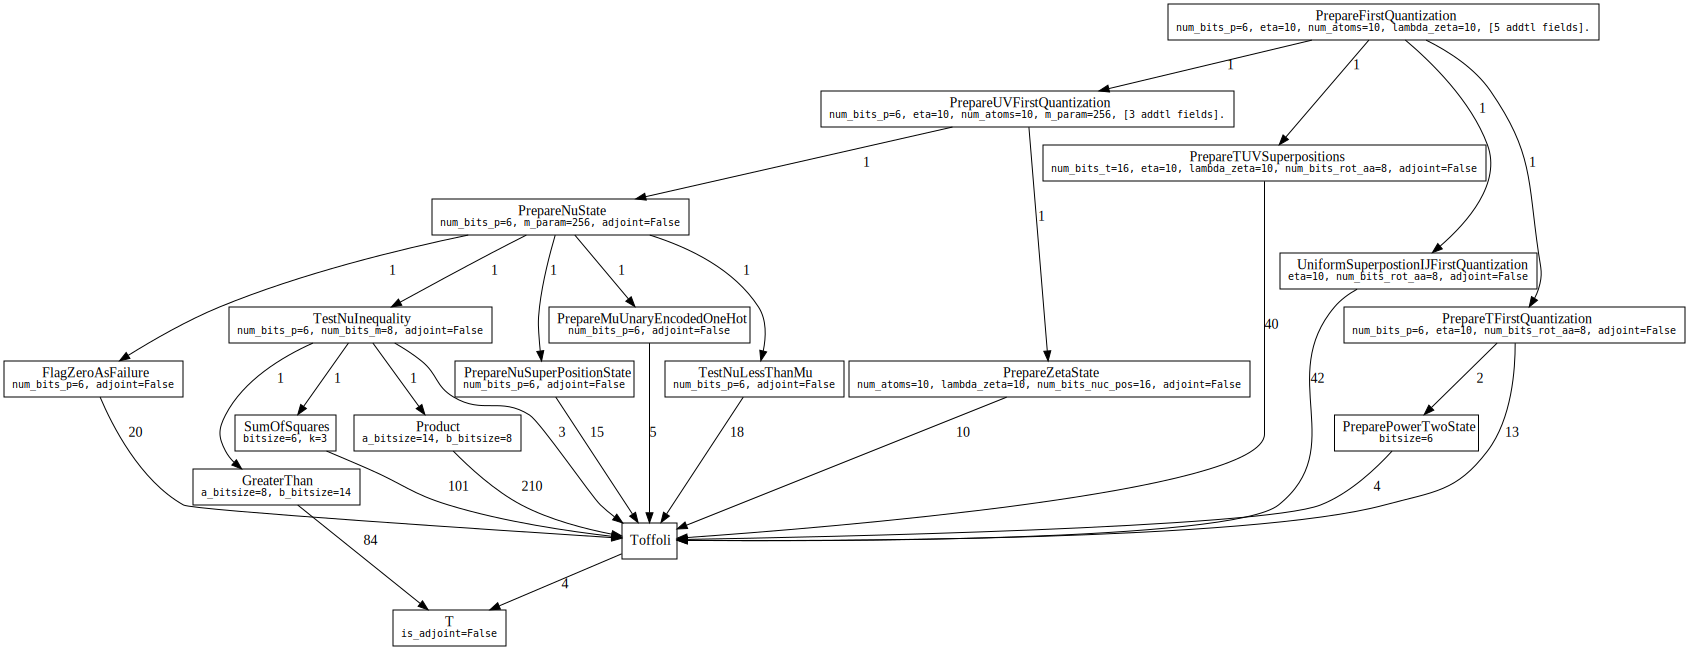

#### Counts totals:
 - `TGate()`: 2024

In [5]:
prep_first_quant_g, prep_first_quant_sigma = prep_first_quant.call_graph()
show_call_graph(prep_first_quant_g)
show_counts_sigma(prep_first_quant_sigma)

## `SelectFirstQuantization`
SELECT operation for the first quantized chemistry Hamiltonian.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms. $L$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `num_bits_nuc_pos`: The number of bits of precision for representing the nuclear coordinates.
 - `num_bits_t`: The number of bits of precision for the state preparation over the register selecting between the different components of the Hamiltonian.
 - `num_bits_rot_aa`: The number of bits of precision for the rotation for amplitude amplification.
 - `adjoint`: Whether to dagger the bloq or not. 

#### Registers
 - `tuv`: Flag register for selecting between kinetic and potential terms in the Hamiltonian.
 - `uv`: Flag register for selecting between the different potential components of the Hamiltonian.
 - `i_ne_j`: Register flagging $i \ne j$
 - `plus_t`: A register prepared in the $|+\rangle$ state.
 - `i`: A register for selecting electronic registers.
 - `j`: A register for selecting electronic registers.
 - `w`: A register for selecting x, y and z components of the momentum register.
 - `r`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `s`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `mu`: A register used for implementing nested boxes for the momentum state preparation.
 - `nu_x`: x component of the momentum register for Coulomb potential.
 - `nu_y`: y component of the momentum register for Coulomb potential.
 - `nu_z`: z component of the momentum register for Coulomb potential.
 - `m`: an ancilla register in a uniform superposition.
 - `l`: The register for selecting the nuclei.
 - `sys`: The system register. Will store $\eta$ registers (x, y and z) compents of size num_bits_p. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](
    https://arxiv.org/abs/2105.12767)


In [6]:
from qualtran.bloqs.chemistry.pbc.first_quantization import SelectFirstQuantization

### Example Instances

In [7]:
num_bits_p = 6
eta = 10
num_atoms = 10
lambda_zeta = 10
sel_first_quant = SelectFirstQuantization(num_bits_p, eta, num_atoms, lambda_zeta)


#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([sel_first_quant],
           ['`sel_first_quant`'])

### Call Graph

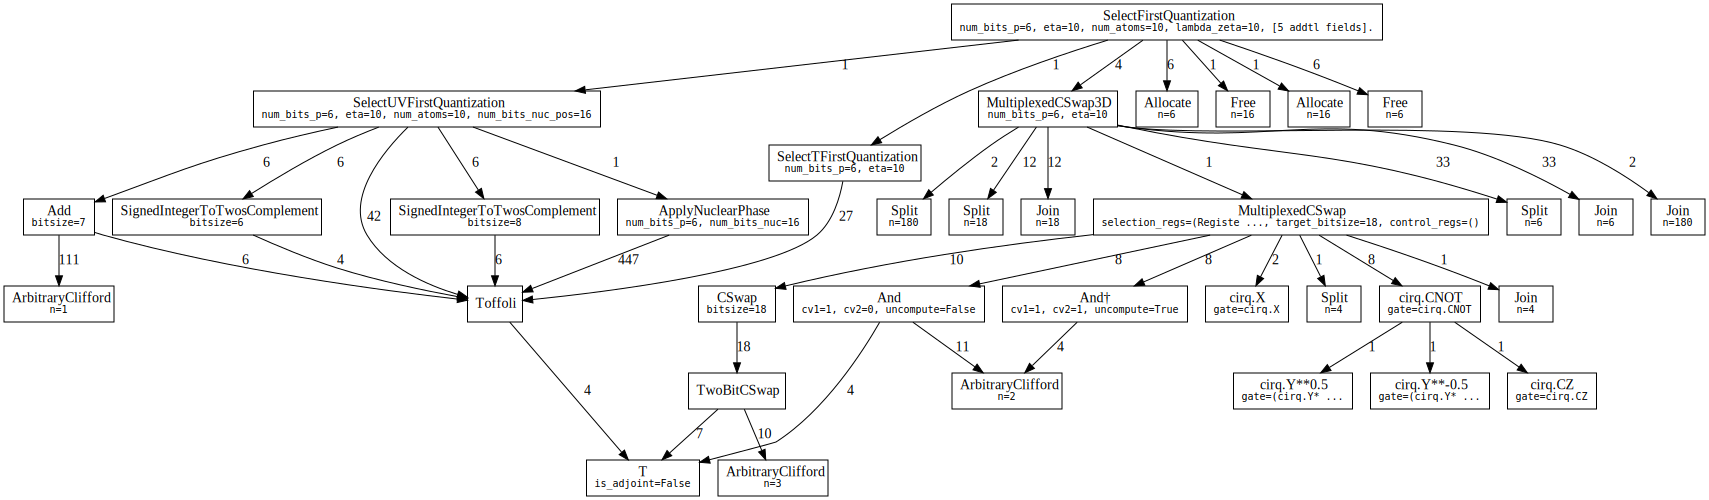

#### Counts totals:
 - `Allocate(n=16)`: 1
 - `Allocate(n=6)`: 6
 - `ArbitraryClifford(n=1)`: 666
 - `ArbitraryClifford(n=2)`: 480
 - `ArbitraryClifford(n=3)`: 7200
 - `CZ`: 32
 - `Free(n=16)`: 1
 - `Free(n=6)`: 6
 - `Join(n=18)`: 48
 - `Join(n=180)`: 8
 - `Join(n=4)`: 4
 - `Join(n=6)`: 132
 - `Split(n=18)`: 48
 - `Split(n=180)`: 8
 - `Split(n=4)`: 4
 - `Split(n=6)`: 132
 - `TGate()`: 7616
 - `X`: 8
 - `Y**-0.5`: 32
 - `Y**0.5`: 32

In [9]:
sel_first_quant_g, sel_first_quant_sigma = sel_first_quant.call_graph()
show_call_graph(sel_first_quant_g)
show_counts_sigma(sel_first_quant_sigma)

## `PrepareTFirstQuantization`
PREPARE for the kinetic energy operator for the first quantized chemistry Hamiltonian.

This prepares the state

$$
    |+\rangle\sum_{j=1}^{\eta}|j\rangle\sum_{w=0}^{2}|w\rangle
    \sum_{r=0}^{n_{p}-2}2^{r/2}|r\rangle
    \sum_{s=0}^{n_{p}-2}2^{s/2}|s\rangle
$$

We assume that the uniform superposition over ($i$ and) $j$ has already occured via
UniformSuperPositionIJFirstQuantization.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_bits_rot_aa`: The number of bits of precision for the single qubit rotation for amplitude amplification. Called $b_r$ in the reference.
 - `adjoint`: whether to dagger the bloq or not. 

#### Registers
 - `w`: a register to index one of three components of the momenta.
 - `r`: a register encoding bits for each component of the momenta.
 - `s`: a register encoding bits for each component of the momenta. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](
    https://arxiv.org/abs/2105.12767) page 19, section B


In [10]:
from qualtran.bloqs.chemistry.pbc.first_quantization.prepare_t import PrepareTFirstQuantization

### Example Instances

In [11]:
num_bits_p = 5
eta = 10

prepare_t = PrepareTFirstQuantization(num_bits_p=num_bits_p, eta=eta)

#### Graphical Signature

In [12]:
from qualtran.drawing import show_bloqs
show_bloqs([prepare_t],
           ['`prepare_t`'])

### Call Graph

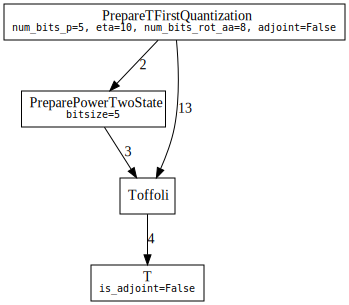

#### Counts totals:
 - `TGate()`: 76

In [13]:
prepare_t_g, prepare_t_sigma = prepare_t.call_graph()
show_call_graph(prepare_t_g)
show_counts_sigma(prepare_t_sigma)

## `PrepareUVFirstQuantization`
PREPARE the U and V parts of the Hamiltonian.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms. $L$ in the reference.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `num_bits_nuc_pos`: The number of bits of precision for representing the nuclear coordinates. 

#### Registers
 - `mu`: The state controlling the nested boxes procedure.
 - `nu`: The momentum transfer register.
 - `m`: an ancilla register in a uniform superposition.
 - `l`: The register for atomic species.
 - `flag_nu`: Flag for success of the state preparation. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](
    https://arxiv.org/abs/2105.12767) page 19, section B


In [14]:
from qualtran.bloqs.chemistry.pbc.first_quantization.prepare_uv import PrepareUVFirstQuantization

### Example Instances

In [15]:
num_bits_p = 5
eta = 10
num_atoms = 10
lambda_zeta = 10
m_param = 2**8
num_bits_nuc_pos = 16

prepare_uv = PrepareUVFirstQuantization(
    num_bits_p=num_bits_p,
    eta=eta,
    num_atoms=num_atoms,
    m_param=m_param,
    lambda_zeta=lambda_zeta,
    num_bits_nuc_pos=num_bits_nuc_pos,
)

#### Graphical Signature

In [16]:
from qualtran.drawing import show_bloqs
show_bloqs([prepare_uv],
           ['`prepare_uv`'])

### Call Graph

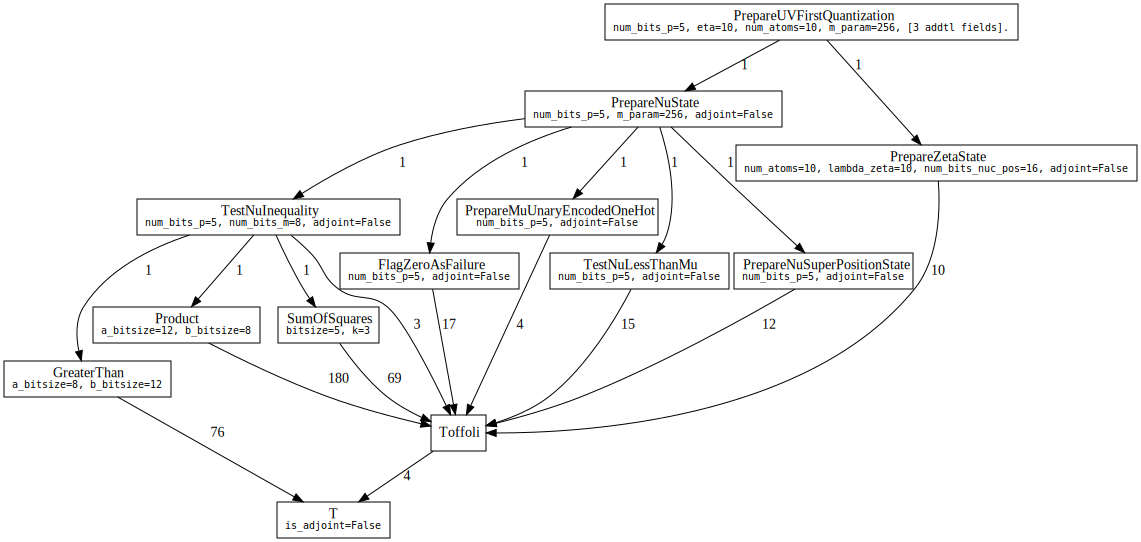

#### Counts totals:
 - `TGate()`: 1316

In [17]:
prepare_uv_g, prepare_uv_sigma = prepare_uv.call_graph()
show_call_graph(prepare_uv_g)
show_counts_sigma(prepare_uv_sigma)

## `SelectTFirstQuantization`
SELECT for the kinetic energy operator for the first quantized chemistry Hamiltonian.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons. 

#### Registers
 - `sys`: The system register.
 - `plus`: A $|+\rangle$ state.
 - `flag_T`: a flag to control on the success of the $T$ state preparation. 

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](
    https://arxiv.org/abs/2105.12767) page 20, section B


In [18]:
from qualtran.bloqs.chemistry.pbc.first_quantization.select_t import SelectTFirstQuantization

### Example Instances

In [19]:
num_bits_p = 5
eta = 10

select_t = SelectTFirstQuantization(num_bits_p=num_bits_p, eta=eta)

#### Graphical Signature

In [20]:
from qualtran.drawing import show_bloqs
show_bloqs([select_t],
           ['`select_t`'])

### Call Graph

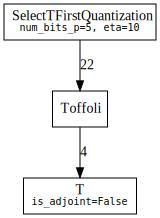

#### Counts totals:
 - `TGate()`: 88

In [21]:
select_t_g, select_t_sigma = select_t.call_graph()
show_call_graph(select_t_g)
show_counts_sigma(select_t_sigma)

## `SelectUVFirstQuantization`
SELECT for the U and V operators for the first quantized chemistry Hamiltonian.

This does not include the controlled swaps from p_i and q_j system registers
into ancilla registers and back again. Hence there is no system register.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms.
 - `num_bits_nuc_pos`: The number of bits to store each component of the nuclear positions. $n_R$ in the reference. 

Registers:

#### References
[Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](
    https://arxiv.org/abs/2105.12767)


In [22]:
from qualtran.bloqs.chemistry.pbc.first_quantization.select_uv import SelectUVFirstQuantization

### Example Instances

In [23]:
num_bits_p = 5
eta = 10
num_bits_nuc_pos = 16

select_uv = SelectUVFirstQuantization(
    num_bits_p=num_bits_p, eta=eta, num_atoms=eta, num_bits_nuc_pos=num_bits_nuc_pos
)

#### Graphical Signature

In [24]:
from qualtran.drawing import show_bloqs
show_bloqs([select_uv],
           ['`select_uv`'])

### Call Graph

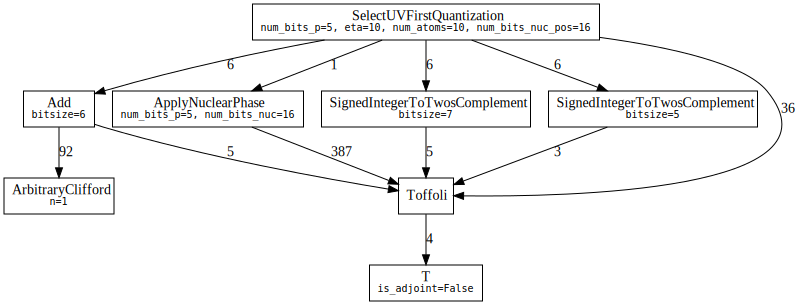

#### Counts totals:
 - `ArbitraryClifford(n=1)`: 552
 - `TGate()`: 2004

In [25]:
select_uv_g, select_uv_sigma = select_uv.call_graph()
show_call_graph(select_uv_g)
show_counts_sigma(select_uv_sigma)